# Review Polarising Impedance $Z_p$ learnt from new random discharge and using prior

In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
sns.set()
%matplotlib inline

In [23]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))


def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()


def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)


SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:

events = Path("/home/chris/Dropbox/Altilium-Magna/Rimac/Proof_of_Concept/data/operational_data/events")
event = pickle.load(open(events / "event_5.p", 'rb'))
Characterisation_Set['Sets'].append({
    "Voltage": event['voltage'].reshape(1, -1),
    "Current": event['current'].reshape(1, -1)
})

In [25]:
for set_i in Characterisation_Set['Sets']:
    print(set_i['Voltage'].shape, set_i['Current'].shape)

(1, 3570) (1, 3570)
(1, 1852) (1, 1852)
(1, 1849) (1, 1849)
(1, 390630) (1, 390630)


In [30]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
        self.f_mean = torch.Tensor([0.0])
        self.f_std = torch.Tensor([0.005])
        self.g_std = 0.01
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])
        self.w_hist = None
        self.voltage_expected_hist = None
        self.soc_expected_hist = None

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L) * torch.exp(gamma * (SoC - 1)) + alpha * v_L * (SoC - 1) \
               + (1 - alpha) * v_L * (torch.exp(-beta) - torch.exp(-beta * torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured):
        first = True
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        self.w_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        self.voltage_expected_hist = torch.empty((1, current.shape[1]), dtype=torch.float)
        self.soc_expected_hist = torch.empty((1, current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        # Bounds
        max_test = soc[:, 0] > 1.0
        soc[max_test, 0] = 1.0
        min_test = soc[:, 0] < 0.0
        soc[min_test, 0] = 0.0000000001
        N = soc_init.shape[0]

        I = torch.ones(N, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, SoC_min, SoC_max)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z

        for t in range(current.shape[1]):

            # Predict SoC
            soc = soc - I*V/Characterisation_Set['E_crit']
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            #SMC
            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            if not first:
                loss = loss + max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
            else:
                loss = max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
                first = False

            # Resampling
            soc, W = resample(soc, loss_W)

            self.w_hist[:, t] = W[:, 0]
            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]
            self.voltage_expected_hist[0, t] = V.transpose(0, 1).mm(W.to(device))
            self.soc_expected_hist[0, t] = soc.transpose(0, 1).mm(W.to(device))

        return loss, voltage, soc_hist

In [31]:
vsmc = RNNetwork()

In [32]:
saved_network = "./Battery_Data/new_battery_cycles/Battery_RNN_from_prior_v4"
parts = 10
N = 100

(1, 1)


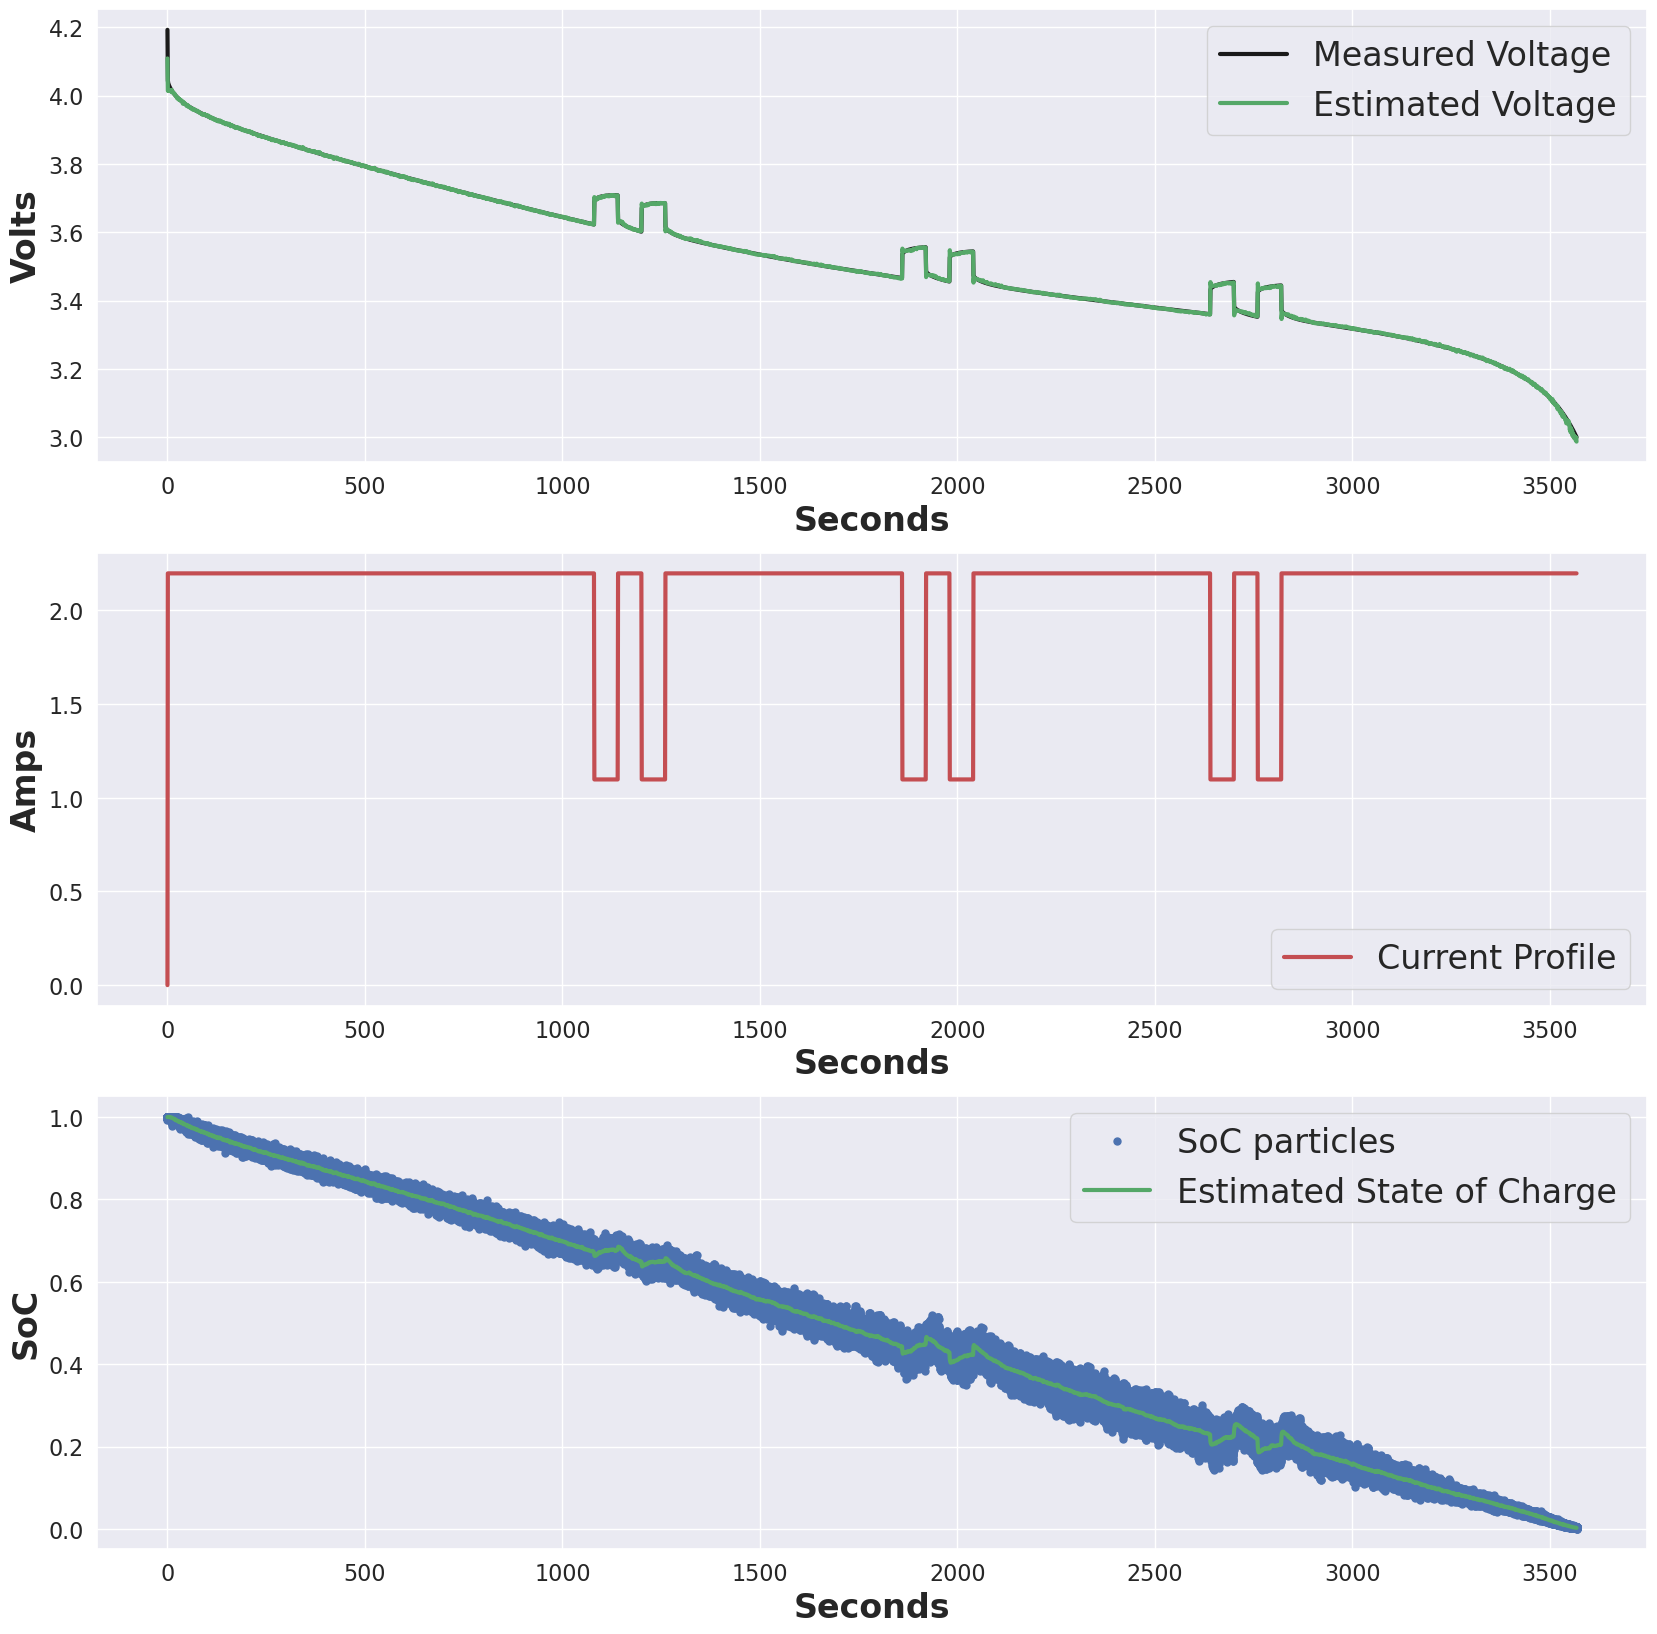

In [33]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
font = {"figure.titlesize": 24,
        "figure.titleweight": 'normal',
        "axes.titlesize" : 24,
        "axes.labelsize" : 24,
        "lines.linewidth" : 3,
        "lines.markersize" : 10,
        "xtick.labelsize" : 16,
        "ytick.labelsize" : 16,
        'axes.labelweight': 'bold',
        'legend.fontsize': 24.0,}
for key in font:
    matplotlib.rcParams[key] = font[key]
saved = "{0}_part_{1}.mdl".format(saved_network, parts)
with torch.no_grad():
    vsmc.load_state_dict(torch.load(saved))
    vsmc.to(device)
    for j, set_dict in enumerate(Characterisation_Set['Sets']):
        if j == 3 or j == 0:
            state = torch.normal(torch.ones([N, 1]) * 0.98, torch.ones([N, 1]) * 0.01).to(device)
            loss, voltage, soc_hist = vsmc(state, set_dict['Current'], set_dict['Voltage'])
            seconds = torch.ones_like(vsmc.voltage_expected_hist).numpy()
            voltage_expected_hist = vsmc.voltage_expected_hist.numpy()
            soc_expected_hist = vsmc.soc_expected_hist.numpy()
            current = np.array(set_dict['Current'])
            pickle.dump({
                "loss": loss, "voltage": voltage, "soc_hist": soc_hist, "seconds": seconds, "voltage_expected_hist": voltage_expected_hist, "soc_expected_hist": soc_expected_hist, "current": current
            }, open("./state_save3_event.p", 'wb'))
            test = set_dict['Voltage'].T < 3.1
            gt_cuttoff = np.array([[-1]])
            print(gt_cuttoff.shape)
            Ecrit_calculated = np.sum(seconds*voltage_expected_hist*current)
            plt.figure()
            plt.subplot(311)
            plt.plot(set_dict['Voltage'].T[:gt_cuttoff[0, 0]], '-k', label="Measured Voltage")
            plt.plot(voltage_expected_hist.T[:gt_cuttoff[0,0]], '-g', label="Estimated Voltage")
            plt.xlabel("Seconds")
            plt.ylabel("Volts")
            plt.legend()
            plt.subplot(312)
            plt.plot(set_dict['Current'].T[:gt_cuttoff[0,0]], '-r', label="Current Profile")
            plt.xlabel("Seconds")
            plt.ylabel("Amps")
            plt.legend()
            plt.subplot(313)
            plt.plot(soc_hist.numpy().T[:gt_cuttoff[0,0], :], '.b')
            plt.plot([],'.b', label="SoC particles")
            plt.plot(soc_expected_hist.T[:gt_cuttoff[0,0]],'-g', label="Estimated State of Charge")
            plt.xlabel("Seconds")
            plt.ylabel("SoC")
            plt.legend()
            plt.show()

(58965, 1)
(58965, 1)
(58965, 1)
(58965, 1)


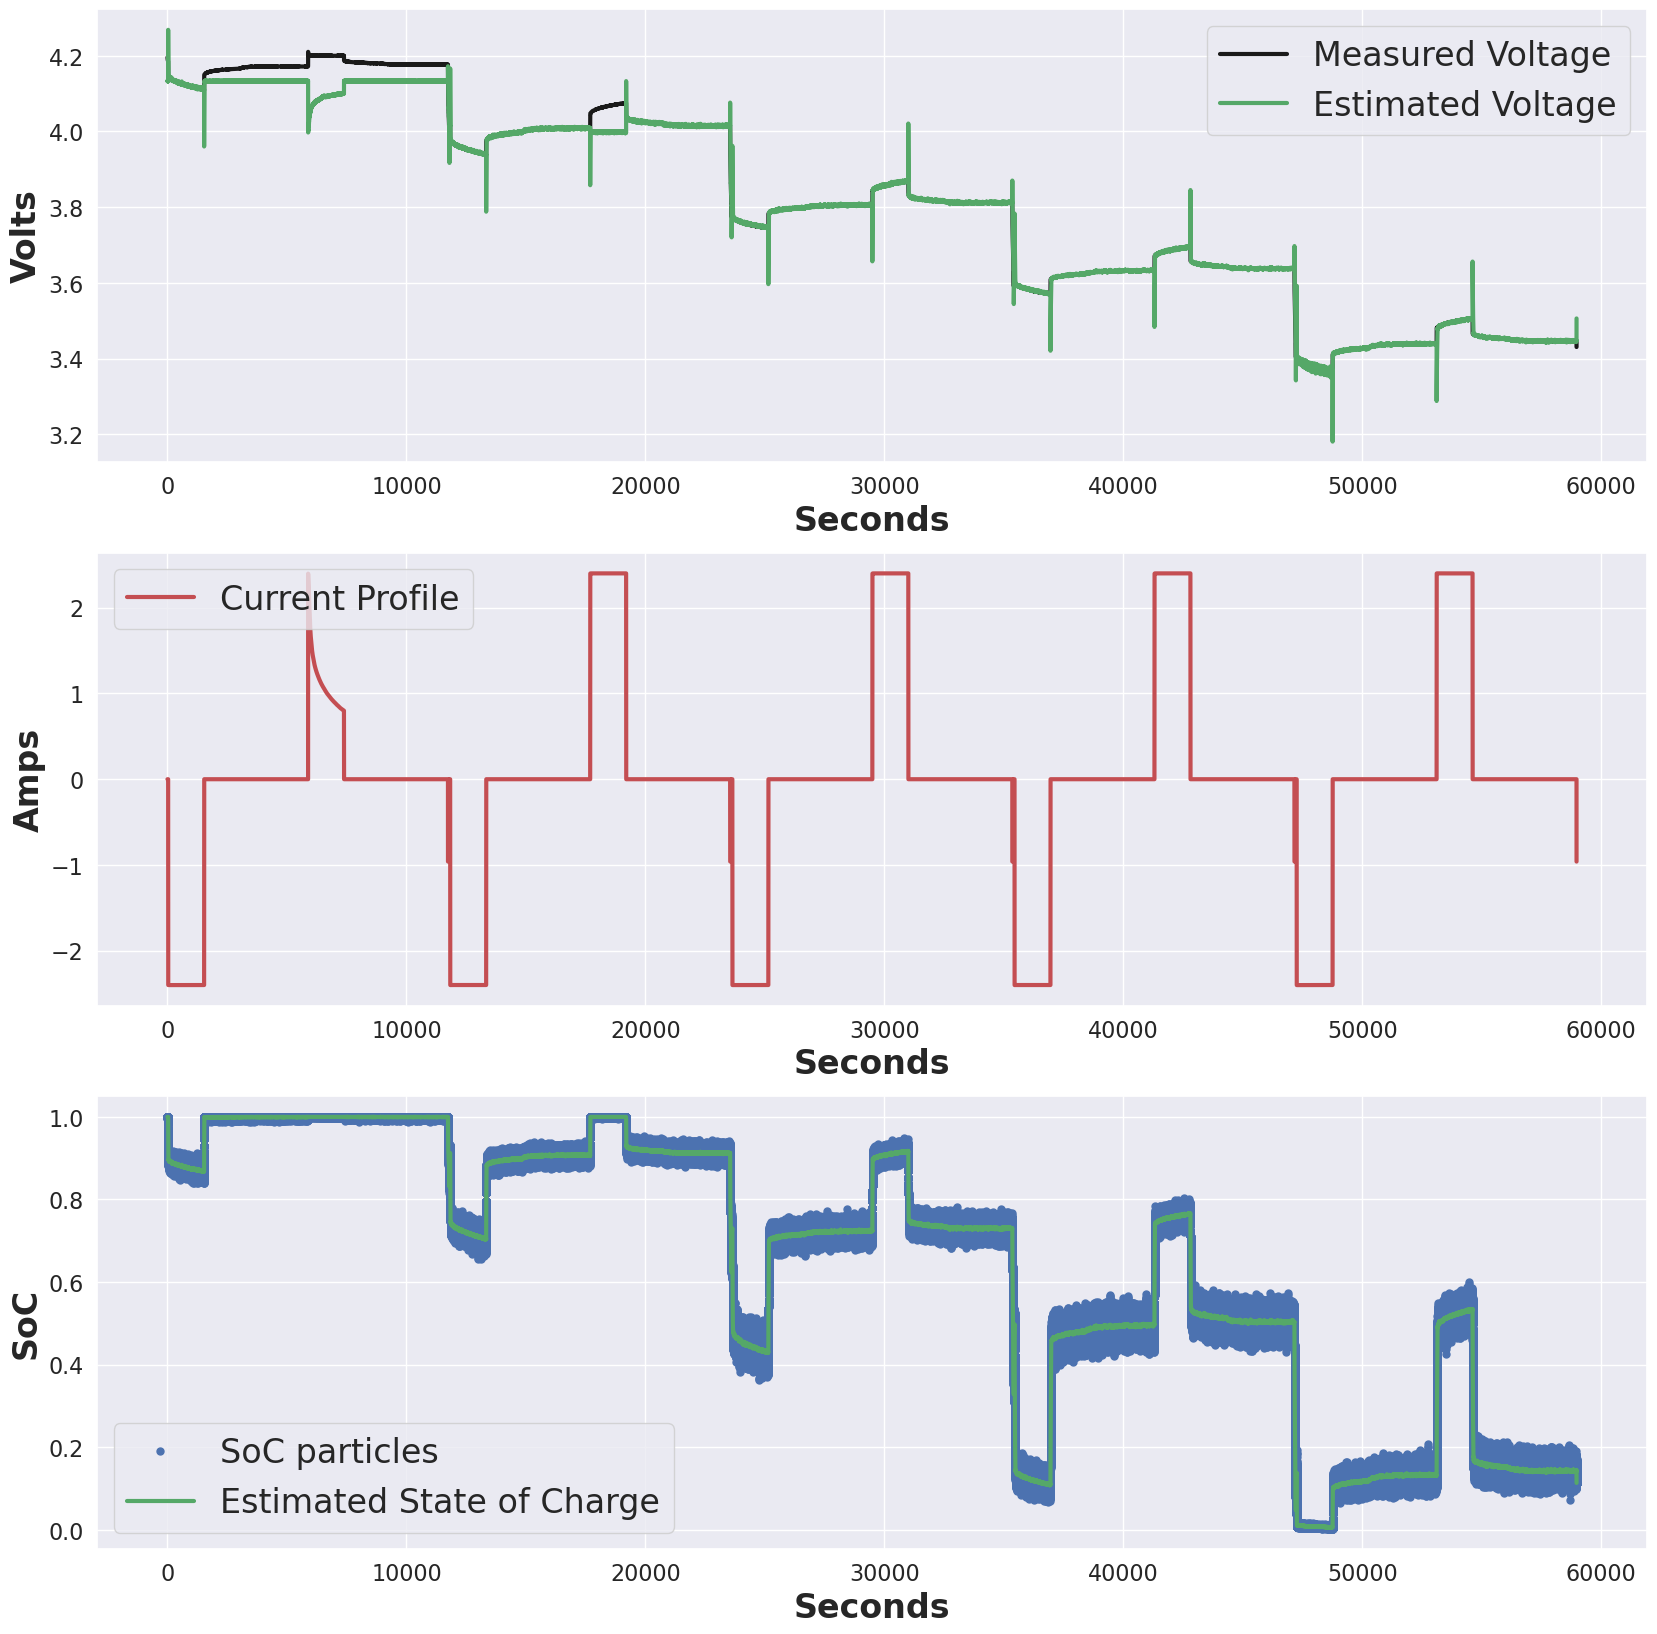

In [22]:
gt_cuttoff = np.array([[-1]])
print(set_dict['Voltage'].T[:gt_cuttoff[0, 0]].shape)
print(voltage_expected_hist.T[:gt_cuttoff[0,0]].shape)
print(set_dict['Current'].T[:gt_cuttoff[0,0]].shape)
print(soc_expected_hist.T[:gt_cuttoff[0,0]].shape)
plt.figure()
plt.subplot(311)
plt.plot(set_dict['Voltage'].T[:gt_cuttoff[0, 0]], '-k', label="Measured Voltage")
plt.plot(voltage_expected_hist.T[:gt_cuttoff[0,0]], '-g', label="Estimated Voltage")
plt.xlabel("Seconds")
plt.ylabel("Volts")
plt.legend()
plt.subplot(312)
plt.plot(set_dict['Current'].T[:gt_cuttoff[0,0]], '-r', label="Current Profile")
plt.xlabel("Seconds")
plt.ylabel("Amps")
plt.legend()
plt.subplot(313)
plt.plot(soc_hist.numpy().T[:gt_cuttoff[0,0], :], '.b')
plt.plot([],'.b', label="SoC particles")
plt.plot(soc_expected_hist.T[:gt_cuttoff[0,0]],'-g', label="Estimated State of Charge")
plt.xlabel("Seconds")
plt.ylabel("SoC")
plt.legend()
plt.show()

In [8]:
class Polarising_Impedance_Map(nn.Module):
    def __init__(self):
        super(Polarising_Impedance_Map, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)

    def forward(self, soc_prior, current_prior):

        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        return Z

In [9]:
Z_pol = Polarising_Impedance_Map()
Z_pol.load_state_dict(torch.load(saved))
Z_pol.to(device)
soc_map = np.array(np.linspace(0, 1.0, 1000), ndmin=2)

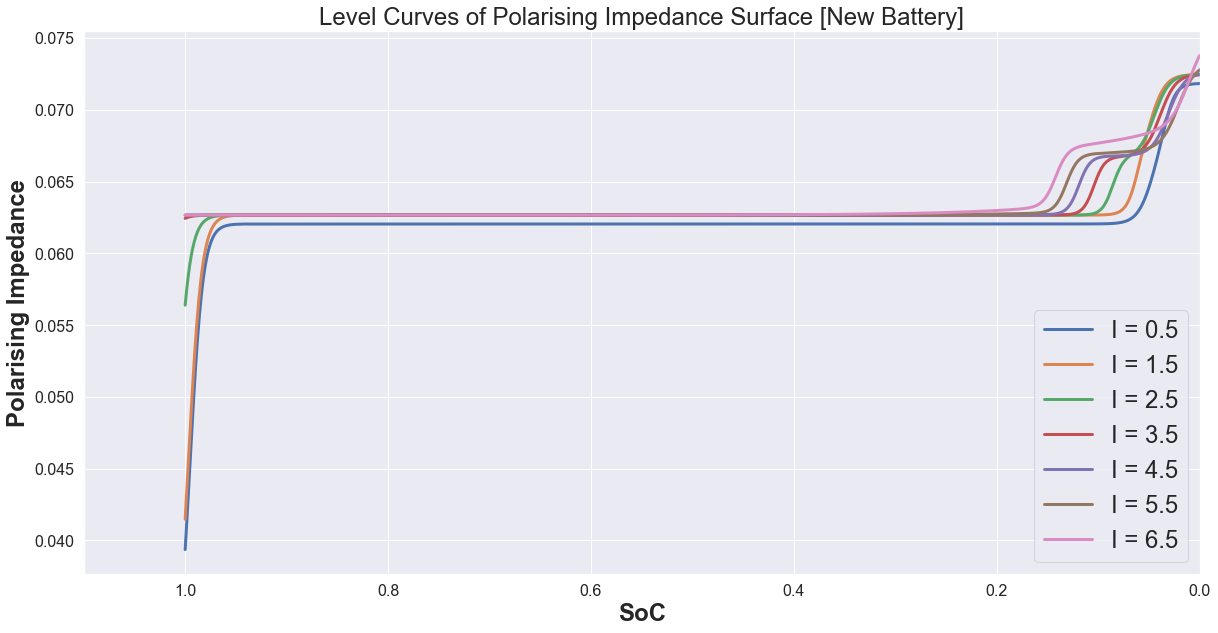

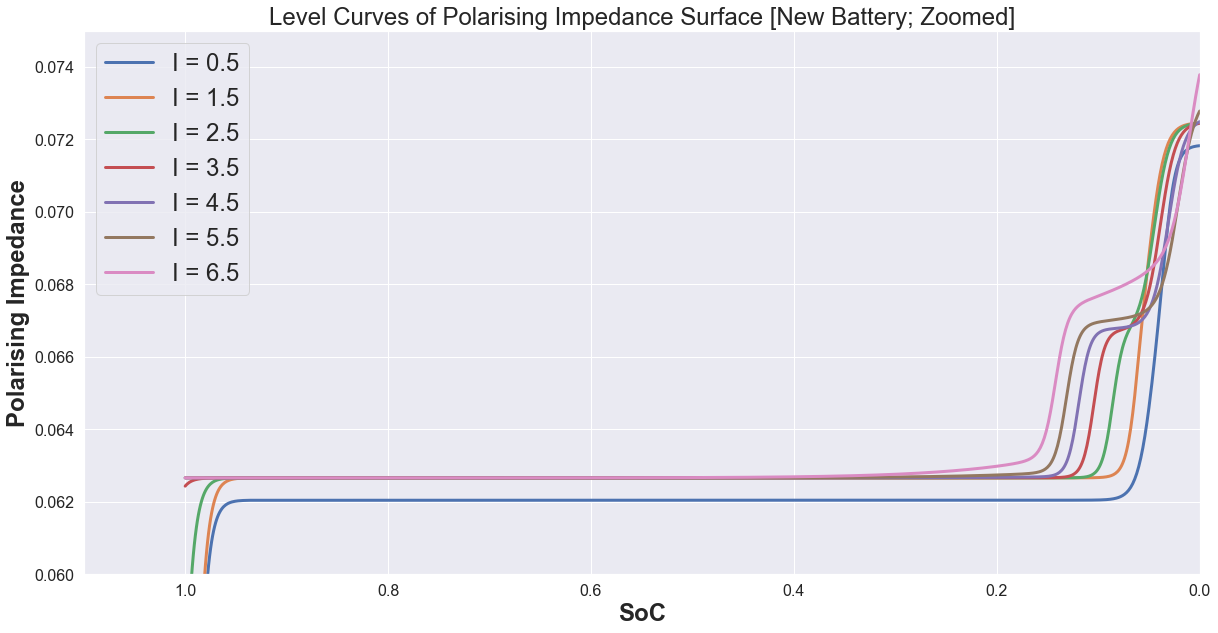

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["axes.labelsize"] = 24
matplotlib.rcParams["axes.labelweight"] = 'bold'
matplotlib.rcParams["axes.titlesize"] = 24

Z_map = []
plt.figure()
current_scale = np.arange(0.5, 7.0, 1.0)
for i in range(current_scale.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*current_scale[i])
        Z_map.append(Z.cpu().numpy())
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(current_scale[i]))
plt.title("Level Curves of Polarising Impedance Surface [New Battery]")
plt.xlabel("SoC")
plt.ylabel("Polarising Impedance")
plt.xlim(1.1, 0.0)  # decreasing soc
plt.legend()
plt.show()

Z_map = []
plt.figure()
current_scale = np.arange(0.5, 7.0, 1.0)
for i in range(current_scale.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*current_scale[i])
        Z_map.append(Z.cpu().numpy())
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(current_scale[i]))
plt.title("Level Curves of Polarising Impedance Surface [New Battery; Zoomed]")
plt.xlabel("SoC")
plt.ylabel("Polarising Impedance")
plt.ylim((0.06, 0.075))
plt.xlim(1.1, 0.0)  # decreasing soc
plt.legend()
plt.show()

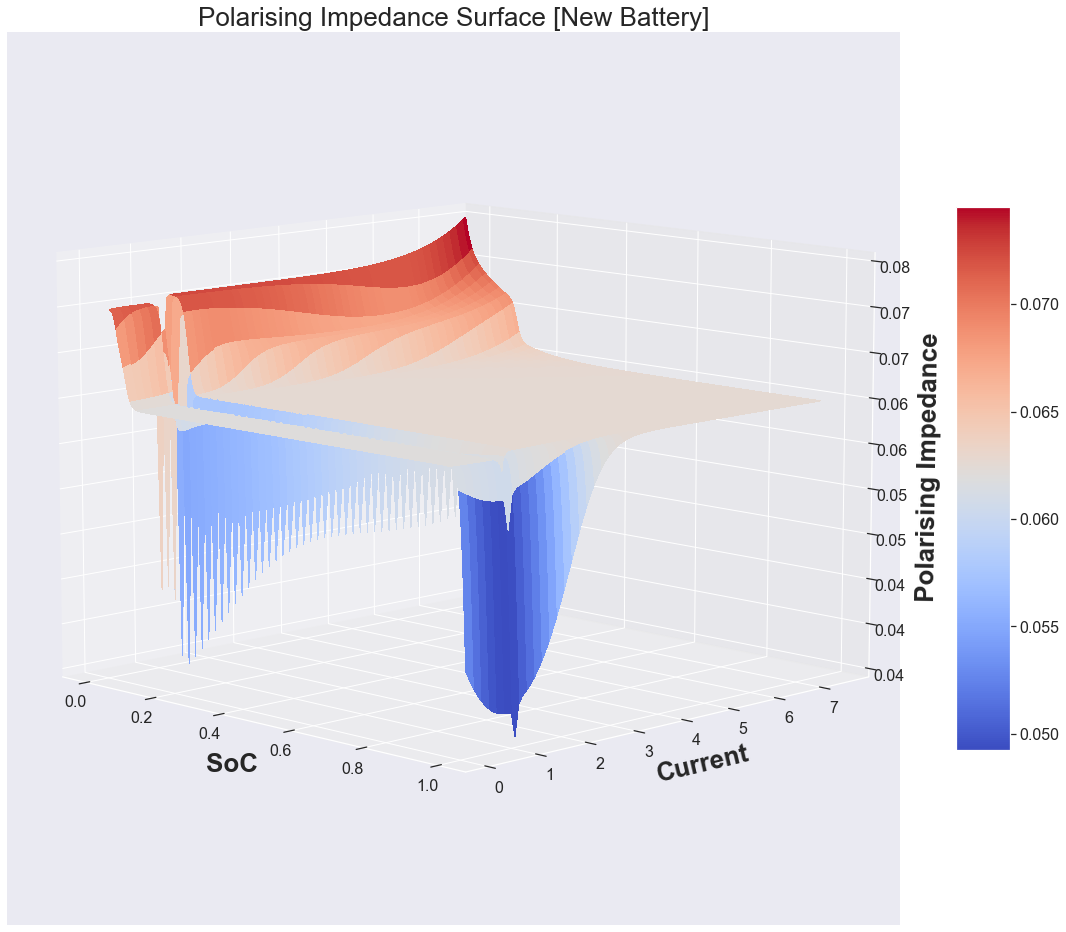

In [21]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
font = {"figure.titlesize": 26,
        "figure.titleweight": 'normal',
        "axes.titlesize" : 26,
        "axes.labelsize" : 26,
        "lines.linewidth" : 3,
        "lines.markersize" : 10,
        "xtick.labelsize" : 16,
        "ytick.labelsize" : 16,
        'axes.labelweight': 'bold',
        'legend.fontsize': 26.0,
       }

for key in font:
    matplotlib.rcParams[key] = font[key]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Polarising Impedance Surface [New Battery]")
# Make data.
X = soc_map
Y = np.linspace(0.1, 7.5, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(10, -45)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel("\nSoC")
plt.ylabel("\nCurrent")
ax.set_zlabel('\nPolarising Impedance')

plt.show()